This code follows the notation from https://iopscience.iop.org/article/10.1088/0266-5611/16/5/321/meta

assumption: here $z_\ell = 1$ for all $1 \leq \ell \leq L$.

In [1]:
import fenics as fn
import numpy as np
from matplotlib import pyplot as plt

$$
\left\{
\begin{array}{rlc}
\nabla \cdot(\gamma(x)\nabla u) &= 0 & \text{ in }\Omega \\
\displaystyle\gamma(x)\frac{\partial u}{\partial n} &= 0 & \text{ over }\Gamma \\
 \displaystyle u + z_\ell \gamma(x)\frac{\partial u}{\partial n} &= U_\ell & \text{ over }e_\ell 
 \\
\displaystyle \int_{e_\ell}\frac{\partial u}{\partial n}\, dS &= I_\ell & \text{ over }e_\ell 
\end{array}
\right.
$$
where $\Gamma = \partial \Omega \setminus \cup_{\ell=1}^{L} e_\ell$

**Parameters**

In [2]:
Ne = 4
# Conductivity
gamma = [1.,10.]
# Impedance
#z = [1.]
# Tolerance 
tol = 1E-14
# electrodes number
L = 4

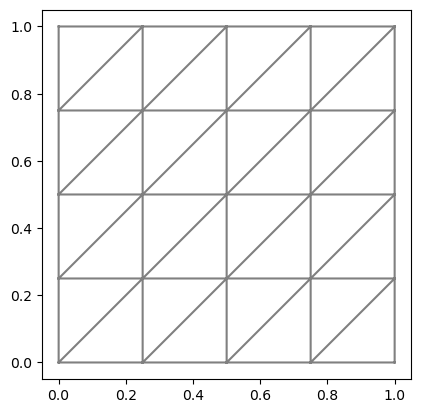

In [3]:
#
h = 1/Ne
#
mesh = fn.UnitSquareMesh(Ne,Ne)
#
fn.plot(mesh)
plt.show()

In [4]:
Uh = fn.FunctionSpace(mesh,'CG',1)
Eh = fn.FunctionSpace(mesh,'DG',0)
#
DofUh = Uh.dim()

**Conductivity**

In [5]:
k_0 = 1.0
k_1 = 0.01
conductivity_str = '(0.25 - tol <= x[0] && x[0] <= 0.5 + tol && 0.25 - tol <= x[1] && x[1] <= 0.5 + tol) ? k_1 : k_0'
conductivity = fn.Expression(conductivity_str, degree=0, tol=tol, k_1=gamma[1], k_0=gamma[0])

**Electrodes**

In [7]:
#
e1_str = '(0.25 - tol <= x[0] && x[0] <= 0.75 + tol && 0. - tol <= x[1] && x[1] <= h + tol) ? 1. : 0.'
e1 = fn.Expression(e1_str,degree=0,h=h,tol=tol)
#
e2_str = '(0. - tol <= x[0] && x[0] <= h + tol && 0.25 - tol <= x[1] && x[1] <= 0.75 + tol) ? 1. : 0.'
e2 = fn.Expression(e2_str,degree=0,h=h,tol=tol)
#
e3_str = '(1.-h - tol <= x[0] && x[0] <= 1. + tol && 0.25 - tol <= x[1] && x[1] <= 0.75 + tol) ? 1. : 0.'
e3 = fn.Expression(e3_str,degree=0,h=h,tol=tol)
#
e4_str = '(0.25 - tol <= x[0] && x[0] <= 0.75 + tol && 1.-h - tol <= x[1] && x[1] <= 1. + tol) ? 1. : 0.'
e4 = fn.Expression(e4_str,degree=0,h=h,tol=tol)
# This works better (it doesn't depend on the mesh)
e_list = [e1,e2,e3,e4]

**Trial and test functions**

In [8]:
uh, vh = fn.TrialFunction(Uh), fn.TestFunction(Uh)

Find $(u,\vec U) \in \mathbb{H}^1\times \mathbb{R}^{L}$ such that:
$$\underbrace{\int_{\Omega} \gamma(x)\nabla u \cdot \nabla v\,dx}_{B_0} + \underbrace{\sum_{\ell=1}^{L}\int_{e_\ell} \frac{1}{z_\ell} v(u - U_\ell)\, dS}_{B_1} = \underbrace{\sum_{\ell=1}^{L} I_\ell V_\ell}_{f}, $$
for all $(v,\vec V)\in \mathbb{H}^{1}\times \mathbb{R}^{L}$.

In [9]:
# Integral of gradients over the domail 
B0 = fn.assemble(conductivity*fn.inner(fn.grad(uh),fn.grad(vh))*(fn.dx)).array()
# Line integral over e1 ... eL
B1_list = []
for l in range(L):
    B1_list.append(fn.assemble(uh*vh*e_list[l]*(fn.ds)).array())
## Line integral over e2
#B2 = fn.assemble(uh*vh*e2*(fn.ds)).array()
## Line integral over e3
#B3 = fn.assemble(uh*vh*e3*(fn.ds)).array()
## Line integral over e4
#B4 = fn.assemble(uh*vh*e4*(fn.ds)).array()

# Put all the matrices together
B = B0
for l in range(L):
    B += B1_list[l]

**C matrix**

$n_j = (1,0,\dots,\underbrace{-1}_{(j+1)-th},\dots,0) \in \mathbb{R}^L$ with $j=1,\dots,L-1$
$$C_{i,j} = -\left( \frac{1}{z_1}\int_{e_1} \varphi_i\, dS - \frac{1}{z_{j+1}}\int_{e_{j+1}} \varphi_i\,\right)$$

In [10]:
C = np.zeros((DofUh,L-1))
for j in range(L-1):
    aux = fn.assemble(uh*e_list[j+1]*(fn.ds))[:] - fn.assemble(uh*e_list[0]*(fn.ds))[:]
    C[:,j] = aux
#print(C)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [11]:
fn.assemble(uh*fn.dx)[:]

array([0.01041667, 0.03125   , 0.03125   , 0.03125   , 0.0625    ,
       0.03125   , 0.03125   , 0.0625    , 0.0625    , 0.03125   ,
       0.02083333, 0.0625    , 0.0625    , 0.0625    , 0.02083333,
       0.03125   , 0.0625    , 0.0625    , 0.03125   , 0.03125   ,
       0.0625    , 0.03125   , 0.03125   , 0.03125   , 0.01041667])

In [12]:
C.shape

(25, 3)

**G matrix**

$$G_{i,j} = \sum_{\ell=1}^{L} \frac{1}{z_\ell}\int_{e_\ell} (n_i)_\ell (n_j)_\ell = 
\begin{cases} 
\frac{|e_1|}{z_1}, & i\neq j \\ 
\frac{|e_1|}{z_1} + \frac{|e_{j+1}|}{z_{j+1}}, & i=j
\end{cases}
$$

It seems that $|e_i| := \int_{e_i} 1\, dS$ (Zamora - page 26)

In [13]:
e_length = 0.5
G = e_length*np.ones((L-1,L-1))
for l in range(L-1):
    G[l,l] += e_length
print(G)

[[1.  0.5 0.5]
 [0.5 1.  0.5]
 [0.5 0.5 1. ]]


**full block matrix $A$**

In [14]:
A = np.block([[B, C], [C.transpose(), G]])

**RHS**

$\mathcal{C}$ matrix (caligraphic C)

In [15]:
calC = np.zeros((L,L-1))
for j in range(L-1):
    calC[j+1,j] = -1
    calC[0,j] = 1
print(calC)

[[ 1.  1.  1.]
 [-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]


**current** $I$

In [16]:
I = np.array([1,-1,1,-1])

In [17]:
hatI      = np.matmul(calC.transpose(),I)
print(hatI)

[2. 0. 2.]


In [18]:
f = np.zeros(DofUh + L-1)
f[DofUh:] = hatI

### Solve the linear system

In [19]:
b = np.linalg.solve(A,f)
alpha = b[:DofUh]
beta  = b[DofUh:]

$u^h$ 

In [20]:
b

array([-5.83156836e-01, -5.70636065e-01, -5.95677607e-01, -4.87547415e-01,
       -3.67537761e-01, -5.84708597e-01, -2.54260299e-01, -6.57757828e-02,
       -2.38061589e-01, -2.79301841e-01,  5.48594235e-17,  1.41756162e-16,
        1.79268056e-16,  3.63398519e-16,  4.59893459e-16,  2.54260299e-01,
        6.57757828e-02,  2.38061589e-01,  2.79301841e-01,  4.87547415e-01,
        3.67537761e-01,  5.84708597e-01,  5.70636065e-01,  5.95677607e-01,
        5.83156836e-01,  2.44999780e+00, -2.51109916e+00,  2.51109916e+00])

$U^h$

In [21]:
alpha

array([-5.83156836e-01, -5.70636065e-01, -5.95677607e-01, -4.87547415e-01,
       -3.67537761e-01, -5.84708597e-01, -2.54260299e-01, -6.57757828e-02,
       -2.38061589e-01, -2.79301841e-01,  5.48594235e-17,  1.41756162e-16,
        1.79268056e-16,  3.63398519e-16,  4.59893459e-16,  2.54260299e-01,
        6.57757828e-02,  2.38061589e-01,  2.79301841e-01,  4.87547415e-01,
        3.67537761e-01,  5.84708597e-01,  5.70636065e-01,  5.95677607e-01,
        5.83156836e-01])

In [22]:
uh_sol = fn.Function(Uh)
uh_sol.vector()[:] = alpha

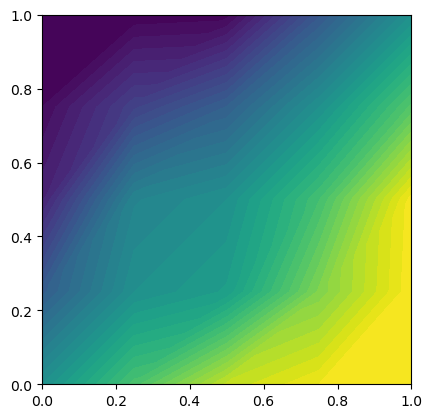

In [23]:
fn.plot(uh_sol)
plt.show()